In [4]:
import sys
import json
import numpy as np
from operator import add
from math import sqrt
# from pyspark import SparkContext
# sc = SparkContext(appName="ParseEventLog")
from pyspark.sql import SQLContext

Goal Here:
* **Summary Bar Plot** 
    * Shows Total Time a job spends in each bucket:
            * average task for each stage 
            * min task for each stage
            * median task for each stage
            * max task for each stage
* **Box and whisker of Task Times in each stage**
* **Box and whisker of Buckets for Each Stage**
* **Stack plot with buckets and error bars for a task for each stage**
* **Average, Median, Min and Max Task for each stage for a few of the nodes over time**

**TODO if stage is a count or collect then classify it as io or metadata**
**TODO: get median thing working**

In [5]:
cx_dict = {'treeAggregate at CX.scala:27': 2, 'collect at IndexedRowMatrix.scala:193': 3, 'parquetFile at CX.scala:168': 1, 'count at CX.scala:189': 1,
           'count at CX.scala:165':0, 'count at CX.scala:166':0 }
                  

pca_dict = {'parquetFile at eofs.scala':0, 'collect at eofs.scala':1, 'count at eofs.scala': 1, 'treeAggregate at eofs.scala': 2, 'collect at IndexedRowMatrix.scala': 3,
                     'treeReduce at eofs.scala': 2,
                     }


phase_names = sc.broadcast(['IO Load Metadata Time', 'IO Load Matrix Time', 'Task Compute Time', 'Finalize/Collect'])
stage_to_phase_dict = sc.broadcast({'cx': cx_dict, 'pca': pca_dict})#, 'randsvd': pca_dict}

In [6]:
items_not_to_subtract = ['Launch Time', 'Finish Time', 'Getting Result Time',
                         'Executor Deserialize Time','Executor Run Time' ,"JVM GC Time", 
                         "Result Serialization Time", 'Task Start Delay', "Time Waiting Until Stage End",
                         'Time To Finish From Stage Start']


misbehaving_tasks=[]
#items_not_applicable = ['Launch Time', 'Finish Time', 'Total Task Time']
items_to_subtract = ['Shuffle Write Time', 'Fetch Wait Time'] #, 'JVM GC Time']


min_or_max_dict = {'min': np.argmin, 'max': np.argmax}

def update_task_dict(task_info, appStart, stage_dic):
    '''Parse task dict for time related keys
    Add Total Task Time, Task Start Delay and Time until stage end to dict'''
    stage_id = task_info["Stage ID"]
    stage_info = get_stage_info(stage_dic, stage_id)
    desired_dict = parse_dict(task_info)
    desired_dict = add_new_members(task_info, desired_dict, stage_info)
    run_tests(desired_dict, stage_info)
    desired_dict = delete_items(desired_dict)
    return desired_dict


def delete_items(desired_dict):
    del_keys = ["Launch Time", "Finish Time", "JVM GC Time"] 
    for k in del_keys:
        del desired_dict[k]
    return desired_dict
        

def add_new_members(task_info, desired_dict,stage_info):
    stage_name, stage_start, stage_end = stage_info
    task_accted_for_time = desired_dict['Executor Run Time'] + desired_dict['Executor Deserialize Time'] + \
                           desired_dict['Result Serialization Time']  + desired_dict['Getting Result Time']
    total_task_time = desired_dict['Finish Time'] - desired_dict['Launch Time']
    

    
    desired_dict['Task End Overheads Time'] = total_task_time - task_accted_for_time
    desired_dict['Time To Finish From Stage Start'] = desired_dict['Finish Time'] - stage_start
    desired_dict['Task Start Delay'] = desired_dict['Launch Time'] - stage_start
    
#     if stage_end < desired_dict['Finish Time']:
     
#             print "Stage end is %d task finish time is %d" % (stage_end, desired_dict['Finish Time'])
#             print task_info["Stage ID"], task_info["Task Info"]["Speculative"]
        
    desired_dict['Time Waiting Until Stage End'] = stage_end - desired_dict['Finish Time']
    
    return desired_dict
    
def run_tests(desired_dict, stage_info):
    #assert False
    stage_name, stage_start, stage_end = stage_info
    total_task_time = desired_dict['Finish Time'] - desired_dict['Launch Time']
    assert desired_dict['Task Start Delay'] +  total_task_time == desired_dict['Time To Finish From Stage Start']
    assert desired_dict['Time To Finish From Stage Start'] + desired_dict['Time Waiting Until Stage End'] == stage_end - stage_start
    sum_ = 0
    for k in ['Executor Run Time',
              'Getting Result Time',
              'Driver Compute Time',
              'Task Start Delay',
              'Result Serialization Time',
              'Task End Overheads Time',
              'Executor Deserialize Time']:

        if k in desired_dict:
            sum_ += desired_dict[k]
        
    assert sum_ == desired_dict['Time To Finish From Stage Start']
#     for k, v in desired_dict.iteritems():
#         assert v >= 0, "Oh no key %s is %d" % (k,v)
    
def get_stage_info(stage_dic, stage_id):
    stage_name = stage_dic[stage_id]['name']
    stage_start = stage_dic[stage_id]['stage_submit_time']
    stage_end =  stage_dic[stage_id]['stage_complete_time']
    return stage_name, stage_start, stage_end
    
def parse_dict(task_info):
    '''get all time related k,value pairs in the task dict from the json event logs
    this is recurtsive b/c we parse dicts inside dicts'''
    desired_dict={}
    for key,value in task_info.iteritems():
        if "Time" in str(key):
            #if "Launch Time" in key or "Finish Time" in key:
                #value = value - appStart
            #convert nanoseconds to milliseconds
            if "Shuffle Write Time" in key:
                value /= 1000000.0
            desired_dict[str(key)] = value
        if isinstance(value,dict):
            d = parse_dict(value)
            desired_dict.update(d)
   


    return desired_dict

def flat_map_dict(key_tuple_plus_dic):
    '''returns a list of nested tuples, where each tuple is 
    ((key_tuple[0], key_tuple[1],...key_tuple[n], dic_key[i]), value[i])'''
    key_tuple, dic = key_tuple_plus_dic
    return [(tuple(list(key_tuple) + [k]),v) for k,v in dic.iteritems()]

def create_compute_bucket(stage_id,dic, algo): #, stage_dic):
    stage_name = str(stage_dict.value[stage_id]['name']) #.split(':')[0]
    if algo == 'cx':
        compute_bucket_id = stage_to_phase_dict.value[algo][stage_name]
    elif algo == 'pca':
        compute_bucket_id = stage_to_phase_dict.value[algo][stage_name.split(':')[0]]
    compute_bucket_name = phase_names.value[compute_bucket_id]

    dic[compute_bucket_name] = dic['Executor Run Time']
    for k in dic.keys():
        if k in items_to_subtract: #and k != compute_bucket_name :
            dic[compute_bucket_name] -= dic[k]
    #dic['subtracts']=subtracts
    return dic

    
def calc_driver_comp_time(stage_dict):
    start_finish_times = [(stage_dict[k]['stage_submit_time'], stage_dict[k]['stage_complete_time']) for k in range(len(stage_dict.keys())) ]
    driver_comp_times = [start_finish_times[i][0] - start_finish_times[i-1][1] for i,t in enumerate(start_finish_times) ]
    driver_comp_times[0] = start_finish_times[0][0] - appStart
    driver_comp_times.append(appEnd - start_finish_times[-1][1])
    total_driver_comp_time = sum(driver_comp_times)
    return total_driver_comp_time

def get_f_task_per_stage(f,stage_keyed_task_info, key):
    if f == 'min':
        ret = stage_keyed_task_info.reduceByKey(lambda v1,v2: v1 if v1[key] < v2[key] else v2)
    elif f == 'max':
        ret = stage_keyed_task_info.reduceByKey(lambda v1,v2: v1 if v1[key] > v2[key] else v2)
    elif f == 'median':
        '''this has some weird hacks: 
            1.collects all the values that fit the key for each stage
            2. locally computes median 
                (but appends an extra value to any lists that are even in lenght, so median will not be an avg of two )
            3. Finds all tasks for a given stage that have the value that matches median for that stage (ie if key is Total Task Time 
            and the median total task time for stage 4 is 50 then gets the task_info dicts for all tasks in stage 4 with Total Task time of 50)
            4. Get rid of duplicates by picking at random one of the median tasks (TODO: get avg or something)
            '''   
        task_dict = stage_keyed_task_info.map(lambda (i,v): (i,v[key])).groupByKey().collectAsMap()
        stage_and_key_keyed_task_info = stage_keyed_task_info.map(lambda (i,v): ((i,v[key]),v))
        #duplicates max value in list to end to make all lists odd
        list_dict ={stage:list(task_value_iter) + ([max(list(task_value_iter))] if len(list(task_value_iter)) % 2 == 0 else []) for stage,task_value_iter in task_dict.iteritems()}
        med_dict = {k:int(np.median(v)) for k,v in list_dict.iteritems()}
        ret = stage_and_key_keyed_task_info\
            .map(lambda ((stage,median_v_key),v): (stage,med_dict[stage], median_v_key, v)).filter(lambda (stage,med,val,v): med==val)\
            .map(lambda (stage,med,val,v): (stage,v))\
            .reduceByKey(lambda v1,v2: v1)
    else:
        assert False, "must specify miin, max or median not %s" % f
    return ret

# def get_f_buckets_per_stage(f,stage_keyed_task_buckets, merge_stages=False):
#     if f == "mean":
#         ret = stage_keyed_task_buckets.reduceByKey(add)\
#                                       .map(lambda (i,v): (i,float(v) / task_counts_dict.value[i[0]] ))
#     elif f == 'min':
#         ret = stage_keyed_task_buckets \
#                 .reduceByKey(min)
#     elif f == 'max':
#         ret = stage_keyed_task_buckets \
#                 .reduceByKey(max)
#     elif f == 'median':
#         ret = stage_keyed_task_buckets \
#             .groupByKey().map(lambda (i,v): (i, np.median(list(v))))
#     if merge_stages:
#         return ret.map(lambda (i,v): (i[1], v)).reduceByKey(add)
#     else:
#         return ret



# def get_stdev_buckets_per_stage(stage_keyed_task_buckets, mean_dict, merge_stages=False):
#     stdevs = stage_keyed_task_buckets\
#             .map(lambda (i,v): (i,(float(v) - b_means.value[i])**2)) \
#             .reduceByKey(add) \
#             .map(lambda (i,v): (i,sqrt(v) / float(task_counts_dict.value[i[0]]))) #.cache()
#     if merge_stages:
#         return stdevs.map(lambda (i,v): (i[1], v)).reduceByKey(add)
#     else:
#         return stdevs
    
def get_summary_tasks_for_mpl(f,stage_keyed_tasks, key, driver_comp_time):
    '''formats the '''
    task_sum_for_mpl = get_f_task_per_stage(f,stage_keyed_tasks, key)\
    .map(lambda (i,v): (tuple([i]), v)).flatMap(flat_map_dict)\
    .map(lambda (i,v): (i[1], v))\
    .reduceByKey(add).collectAsMap()
    
    #add driver compute time
    task_sum_for_mpl.update({'Driver Compute Time': driver_comp_time})

        
    return task_sum_for_mpl
    
def get_app_start(log_rdd):
    appStart = log_rdd.filter(lambda x: "SparkListenerApplicationStart" in x)\
                   .map(lambda x: int(json.loads(x)["Timestamp"])).take(1)[0]
    return appStart
    
    
def get_app_end(log_rdd):
    
    appEnd = log_rdd.filter(lambda x: "SparkListenerApplicationEnd" in x)\
                   .map(lambda x: int(json.loads(x)["Timestamp"])).take(1)[0]
    return appEnd

def make_stage_dict(log_rdd):
    stage_info = loglines.filter(lambda x: "SparkListenerStageCompleted" in x)\
                     .map(lambda x: json.loads(x)["Stage Info"])\
                     .map(lambda stageEvent: (stageEvent["Stage ID"],
                                 stageEvent["Stage Name"],int(stageEvent["Submission Time"]),
                                                         int(stageEvent["Completion Time"] )))
    stage_dict = sc.broadcast({tup[0] : dict(zip([ 'name','stage_submit_time', 'stage_complete_time'],tup[1:])) for tup in stage_info.collect()})
    return stage_dict
    
    

In [10]:
event_log = '/project/projectdirs/paralleldb/spark/benchmarks/cx/event_logs/app-20160330000824-0000'
#'/project/projectdirs/paralleldb/spark/benchmarks/pca_climate/large-scale-climate/eventLogs/app-20160325035651-0000'
#'/project/projectdirs/paralleldb/spark/benchmarks/cx/event_logs/app-20160310010018-0000' 
#'/project/projectdirs/paralleldb/spark/benchmarks/pca_climate/large-scale-climate/eventLogs/app-20160325050003-0000'
#'/project/projectdirs/paralleldb/spark/benchmarks/pca_climate/large-scale-climate/eventLogs/app-20160325050003-0000'
algo_name='cx'
loglines = sc.textFile(event_log).cache()

In [11]:
appStart, appEnd = [get_app_start(loglines), get_app_end(loglines)]

stage_dict = make_stage_dict(loglines)
driver_comp_time = calc_driver_comp_time(stage_dict.value)

In [12]:
task_info = loglines.filter(lambda x: "SparkListenerTaskEnd" in x)\
                    .map(lambda x: json.loads(x))\
                    .map(lambda taskInfo: 
                         ( 
                            (taskInfo["Stage ID"],
                            int(taskInfo["Task Info"]["Executor ID"])),
                taskInfo )).map(lambda (i,v): (i,update_task_dict(v, appStart, stage_dict.value)))\
      .map(lambda (i,v): (i,create_compute_bucket(i[0],v,algo_name))).cache() #, stage_dict.value, stage_to_phase_dict.value)))

Figure out what to do with the GC Time Stuff

In [13]:
# flat_task_info = task_info.flatMap(flat_map_dict).cache()
# stage_keyed_task_buckets = flat_task_info.map(lambda (i,v): ((i[0], i[2]), v)).cache()
#task_counts_dict = sc.broadcast(stage_keyed_task_info.map(lambda (i,v): (i,1)).reduceByKey(add).collectAsMap())

In [14]:
stage_keyed_task_info = task_info.map(lambda (i,v): (i[0],v))

In [15]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random
plt.rcParams['figure.figsize'] = (10.0, 8.0)

#Plot Summary Using Max/Min/Median **TASK** in each Stage

In [16]:
maxes_for_mpl = get_summary_tasks_for_mpl('max', stage_keyed_task_info,"Time To Finish From Stage Start", driver_comp_time)
mins_for_mpl = get_summary_tasks_for_mpl('min', stage_keyed_task_info,"Time To Finish From Stage Start",driver_comp_time)

In [17]:
medians_for_mpl = get_summary_tasks_for_mpl('median', stage_keyed_task_info,"Time To Finish From Stage Start",driver_comp_time)

In [31]:
keys = [k for  k in mins_for_mpl.keys() if k not in ['Time To Finish From Stage Start', 'Executor Run Time']]

In [34]:
ordered_keys = ['IO Load Metadata Time','IO Load Matrix Time','Driver Compute Time', 'Task Start Delay',
        'Executor Deserialize Time', 'Task Compute Time', 'Shuffle Write Time', 'Fetch Wait Time',
                'Result Serialization Time', 'Finalize/Collect','Getting Result Time', 'Task End Overheads Time','Time Waiting Until Stage End' ]

In [35]:
assert len(set(keys).difference(ordered_keys)) == 0

In [36]:
maxes_sum = sum([maxes_for_mpl[k] for k in keys if k!= 'Driver Compute Time' and  k!= 'Time Waiting Until Stage End'])

In [37]:
del k

In [38]:
maxes_sum

188036.0

In [39]:
maxes_for_mpl

{'Driver Compute Time': 372149,
 'Executor Deserialize Time': 10026,
 'Executor Run Time': 45744,
 'Fetch Wait Time': 682,
 'Finalize/Collect': 170,
 'Getting Result Time': 0,
 'IO Load Matrix Time': 2267,
 'IO Load Metadata Time': 1026,
 'Result Serialization Time': 138,
 'Shuffle Write Time': 45.958314,
 'Task Compute Time': 41553.041686,
 'Task End Overheads Time': 29812,
 'Task Start Delay': 102316,
 'Time To Finish From Stage Start': 188036,
 'Time Waiting Until Stage End': 8}

In [40]:
medians_for_mpl

{'Driver Compute Time': 372149,
 'Executor Deserialize Time': 3129,
 'Executor Run Time': 34468,
 'Fetch Wait Time': 118,
 'Finalize/Collect': 167,
 'Getting Result Time': 0,
 'IO Load Matrix Time': 1544,
 'IO Load Metadata Time': 702,
 'Result Serialization Time': 134,
 'Shuffle Write Time': 60.603588,
 'Task Compute Time': 31876.396412000002,
 'Task End Overheads Time': 32938,
 'Task Start Delay': 56722,
 'Time To Finish From Stage Start': 127391,
 'Time Waiting Until Stage End': 60653}

In [41]:
 assert np.abs(maxes_sum - maxes_for_mpl['Time To Finish From Stage Start']) < 0.1

In [42]:
total_app_time = maxes_for_mpl['Time To Finish From Stage Start'] + maxes_for_mpl['Driver Compute Time'] + maxes_for_mpl['Time Waiting Until Stage End'] 

In [43]:
assert total_app_time ==  appEnd - appStart

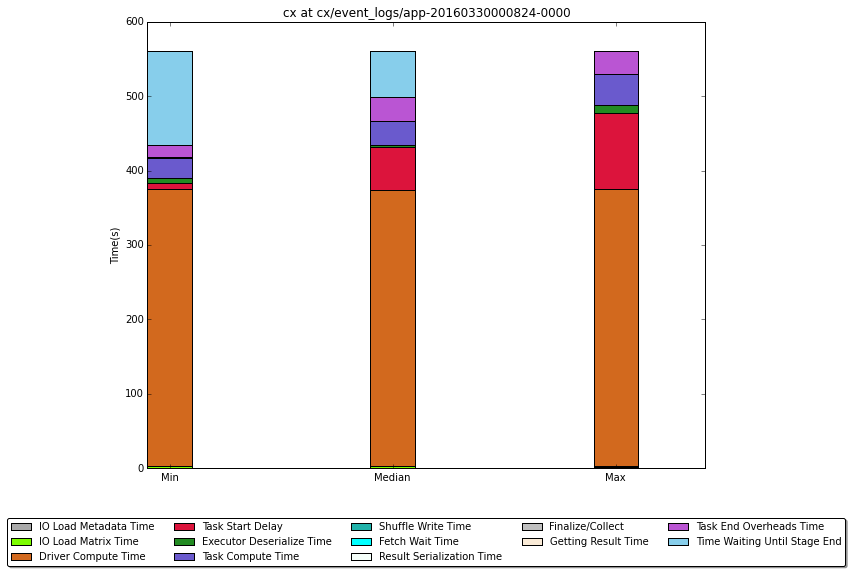

In [44]:
bottom = (0,0,0)
bars = []
colors_ = colors.cnames.keys()
offset = 40
patterns = ('-', '+', 'x', '\\', '*', '.')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ind = np.arange(3)
width = 0.2
for i,k in enumerate(ordered_keys):
    cur_values = np.asarray([c_mpl[k] / 1000. for c_mpl in [mins_for_mpl, medians_for_mpl, maxes_for_mpl]])
    bar = ax1.bar(ind, cur_values,
                        width=width,color=colors_[i+offset], bottom=bottom,
                         ecolor='k')

    bottom = bottom + cur_values

ax1.legend(ordered_keys, loc='upper center', bbox_to_anchor=(0.5, -0.1),
                  fancybox=True, shadow=True, ncol=5, prop={'size': 10})
plt.ylabel('Time(s)')
plt.xticks(ind + width/2., ('Min', 'Median', 'Max'))
plt.title("%s at %s"% (algo_name, event_log.split('benchmarks/')[1]))
plt.show()